In [102]:
%%capture
from pathlib import Path

if Path.cwd().stem == "models":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [103]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import optuna
import polars as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from icecream import ic
from polars import col
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    GroupShuffleSplit,
)
from torch.utils.data import DataLoader, TensorDataset

from src.data.database_manager import DatabaseManager
from src.features.utils import to_describe
from src.log_config import configure_logging
from src.models.architectures import MultiLayerPerceptron
from src.models.utils import StandardScaler3D

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

db = DatabaseManager()

In [108]:
with db:
    labels = db.get_table("Labels")

In [128]:
labels = labels.with_columns(
    # Add time counter for decreases and strictly increases
    (
        pl.when(col("strictly_increasing_intervals") != 0)
        .then(
            col("timestamp")
            - col("timestamp").min().over("strictly_increasing_intervals")
        )
        .otherwise(None)
    ).alias("normalized_timestamp_increases"),
    (
        pl.when(col("decreasing_intervals") != 0)
        .then(col("timestamp") - col("timestamp").min().over("decreasing_intervals"))
        .otherwise(None)
    ).alias("normalized_timestamp_decreases"),
    # Only keep the first 5 seconds
).filter(
    (col("normalized_timestamp_increases") < 5000)
    | (col("normalized_timestamp_decreases") < 5000)
)

In [129]:
# Split data into decreasing and increasing intervals to add labels and sample ids
decreases = labels.filter(
    col("normalized_timestamp_decreases").is_not_null()
).with_columns(
    pl.lit(1).alias("label").cast(pl.UInt8),
    col("decreasing_intervals").alias("sample_id"),
)
increases = labels.filter(
    col("normalized_timestamp_increases").is_not_null()
).with_columns(
    pl.lit(0).alias("label").cast(pl.UInt8),
    (
        col("strictly_increasing_intervals")
        + (decreases.select(pl.last("decreasing_intervals")))  # continue from decreases
    ).alias("sample_id"),
)
# Join the two tables back together
labels = decreases.vstack(increases).sort("sample_id", "timestamp")

In [130]:
# Normalize the data
ROWS_PER_SAMPLE = 50

labels = (
    labels.group_by("sample_id", maintain_order=True)
    .agg(pl.all().head(ROWS_PER_SAMPLE))
    .explode(pl.all().exclude("sample_id"))  # Explode the result back into rows
)

# Sanity check
if not labels.height == labels.select(pl.last("sample_id")).item() * ROWS_PER_SAMPLE:
    affected_samples = []
    for sample_id, group in labels.group_by("sample_id", maintain_order=True):
        if group.height < ROWS_PER_SAMPLE or group.height > ROWS_PER_SAMPLE:
            affected_samples.append(sample_id[0])  # sample_id is a tuple
logging.debug(
    f"Normalizing to equal {ROWS_PER_SAMPLE} rows per sample was not successful for the following samples: {affected_samples}"
)
labels = labels.filter(~col("sample_id").is_in(affected_samples))

17:34:43 | DEBUG   | root | Normalizing to equal 50 rows per sample was not successful for the following samples: [1310, 2143, 2428, 2641]


In [81]:
labels = labels.select(
    "sample_id",
    "participant_id",
    "rating",
    "temperature",
    "label",
)
labels

sample_id,participant_id,rating,temperature,label
u16,u8,f64,f64,u8
1,1,0.83375,0.80056,1
1,1,0.83375,0.800524,1
1,1,0.8375,0.800415,1
1,1,0.83875,0.800232,1
1,1,0.83875,0.799977,1
1,1,0.83875,0.799649,1
…,…,…,…,…
2656,28,0.66375,0.476868,0
2656,28,0.6675,0.485034,0


In [82]:
def create_time_series_features(
    df: pl.DataFrame,
    columns: list[str],
    group_by_col: str = "sample_id",
) -> np.ndarray:
    """
    Convert polars DataFrame to numpy array formatted for time series modeling.

    Args:
        df: Input DataFrame
        columns: List of column names to use as features
        group_by_col: Column name to group by (default: "sample_id")

    Returns:
        numpy array with shape (samples, time steps, features)

    Note:
        Can be easily plotted using ipywidgets with the following code:
        ```python
        import ipywidgets


        @ipywidgets.interact(trial=(0, X.shape[0] - 1))
        def plot_trial(trial):
            for i in range(X.shape[2]):
                plt.plot(X[trial, :, i])
            plt.ylim(0, 1)
        ```
    """
    # Group by sample_id and aggregate all specified columns
    X = df.group_by(group_by_col, maintain_order=True).agg(
        [pl.col(col) for col in columns]
    )

    # Handle both univariate and multivariate cases
    if len(columns) == 1:
        X = np.vstack(X.get_column(columns[0]).to_numpy())
        X = np.expand_dims(X, axis=2)
    else:
        feature_arrays = [np.vstack(X.get_column(col).to_numpy()) for col in columns]
        X = np.stack(feature_arrays, axis=2)

    return X


In [132]:
X = create_time_series_features(labels, columns=["rating"])
y = (
    labels.group_by("sample_id")
    .agg((col("label").first()))
    .get_column("label")
    .to_numpy()
)
groups = (
    labels.group_by("sample_id")
    .agg((col("participant_id").first()))
    .get_column("participant_id")
    .to_numpy()
)

In [85]:
# np.save("data/x.npy", x)
# np.save("data/y.npy", y)
# np.save("data/groups.npy", groups)

In [133]:
# Create a single train-test split while respecting group structure in the data
splitter = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=groups))
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]


In [87]:
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cpu")
)
logging.debug(f"Using device: {device}")
batch_size = 64


17:00:56 | DEBUG   | root | Using device: mps


In [89]:
def create_dataloaders(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    batch_size: int,
    is_test: bool = True,
) -> tuple[DataLoader, DataLoader]:
    # Sanity check
    assert (
        len(X_train.shape) == len(X_test.shape) == 3
    ), "X_train and X_test must have 3 dimensions: (samples, timesteps, features)"

    scaler = StandardScaler3D()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    train_data = TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train).view(-1, 1),
    )
    test_data = TensorDataset(
        torch.FloatTensor(X_test),
        torch.FloatTensor(y_test).view(-1, 1),
    )
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

    dataset = "Test" if is_test else "Validation"
    logging.debug(
        f"Train Data: {len(train_data)} samples, "
        f"{dataset} Data: {len(test_data)} samples"
    )

    return train_loader, test_loader


train_loader, test_loader = create_dataloaders(
    X_train,
    y_train,
    X_test,
    y_test,
    batch_size=batch_size,
)


17:00:56 | DEBUG   | root | Train Data: 1311 samples, Test Data: 1341 samples


In [90]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    criterion: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    epochs: int,
    is_test: bool = True,
) -> dict[str, list[float]]:
    dataset = "test" if is_test else "validation"
    history = {
        "train_accuracy": [],
        "train_loss": [],
        f"{dataset}_accuracy": [],
        f"{dataset}_loss": [],
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        # for acc metric only
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

            # Calculate training accuracy
            y_pred_classes = (torch.sigmoid(outputs) >= 0.5).float()
            total += y_batch.size(0)
            correct += (y_pred_classes == y_batch).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total if total > 0 else 0
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

        # Store the metrics in the history dictionary
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history[f"{dataset}_loss"].append(test_loss)
        history[f"{dataset}_accuracy"].append(test_accuracy)

        # Log progress
        max_digits = len(str(epochs))
        logging.debug(
            f"E[{+epoch+1:>{max_digits}d}/{epochs}] "
            f"| train {epoch_loss:.4f} ({epoch_acc:.1%}) "
            f"· {dataset} {test_loss:.4f} ({test_accuracy:.1%})"
        )

    return history


def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.modules.loss._Loss,
) -> tuple[float, float]:
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred_logits = model(X_batch)
            loss = criterion(y_pred_logits, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            # Metric here is acc
            y_pred_classes = (torch.sigmoid(y_pred_logits) >= 0.5).float()
            total += y_batch.size(0)
            correct += (y_pred_classes == y_batch).sum().item()

    average_loss = total_loss / total if total > 0 else 0
    accuracy = correct / total if total > 0 else 0
    return average_loss, accuracy


In [134]:
from time_series_library.models import TimesNet

model = TimesNet(
    input_size=X_train.shape[2],
    hidden_size=32,
    num_layers=2,
    output_size=1,
    dropout=0.5,
)


In [96]:
lr = 1e-3
epochs = 20
model = MultiLayerPerceptron(
    input_size=X.shape[2] * X.shape[1],  # 2D input length
    hidden_size=2048,
).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

history = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=epochs,
    is_test=True,
)

17:01:28 | DEBUG   | root | E[ 1/50] | train 0.0491 (99.3%) · test 0.0004 (100.0%)
17:01:29 | DEBUG   | root | E[ 2/50] | train 0.0002 (100.0%) · test 0.0000 (100.0%)
17:01:29 | DEBUG   | root | E[ 3/50] | train 0.0000 (100.0%) · test 0.0000 (100.0%)
17:01:29 | DEBUG   | root | E[ 4/50] | train 0.0000 (100.0%) · test 0.0000 (100.0%)
17:01:29 | DEBUG   | root | E[ 5/50] | train 0.0000 (100.0%) · test 0.0000 (100.0%)
17:01:30 | DEBUG   | root | E[ 6/50] | train 0.0000 (100.0%) · test 0.0000 (100.0%)
17:01:30 | DEBUG   | root | E[ 7/50] | train 0.0000 (100.0%) · test 0.0000 (100.0%)
17:01:30 | DEBUG   | root | E[ 8/50] | train 0.0000 (100.0%) · test 0.0000 (100.0%)
17:01:30 | DEBUG   | root | E[ 9/50] | train 0.0000 (100.0%) · test 0.0001 (100.0%)
17:01:30 | DEBUG   | root | E[10/50] | train 0.0000 (100.0%) · test 0.0001 (100.0%)
17:01:31 | DEBUG   | root | E[11/50] | train 0.0000 (100.0%) · test 0.0001 (100.0%)
17:01:31 | DEBUG   | root | E[12/50] | train 0.0000 (100.0%) · test 0.0001 (1

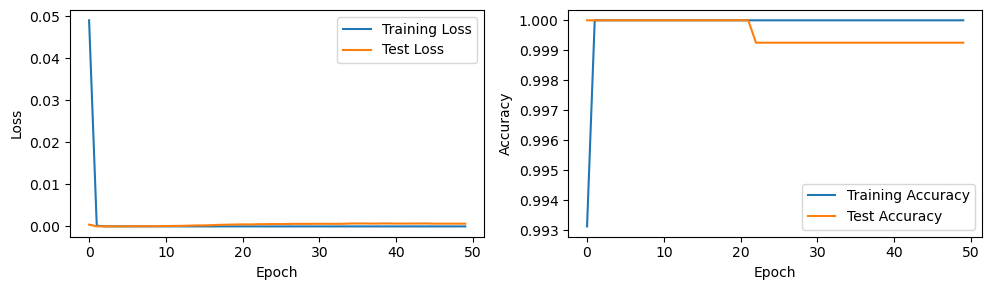

In [97]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history["train_accuracy"], label="Training Accuracy")
plt.plot(history["test_accuracy"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

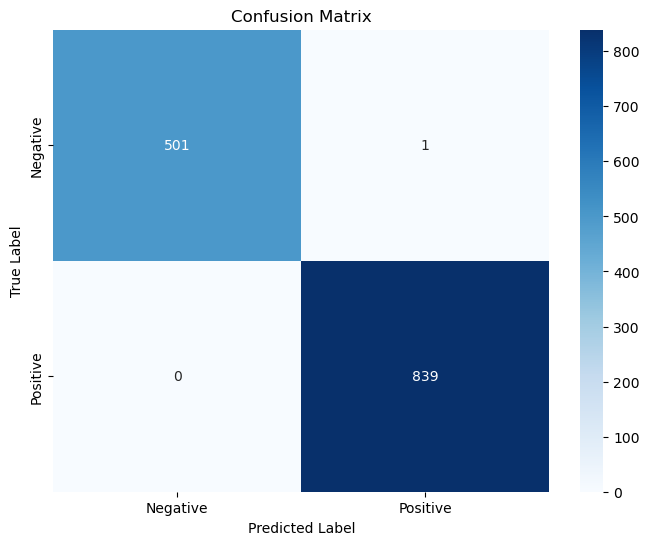

In [98]:
def get_confusion_matrix(
    model: nn.Module,
    test_loader: DataLoader,
    threshold: float = 0.5,
) -> np.ndarray:
    """
    Calculate confusion matrix for binary classification.
    Returns a 2x2 numpy array where:
    [0,0] = TN, [0,1] = FP
    [1,0] = FN, [1,1] = TP
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            y_pred_batch = (torch.sigmoid(outputs) >= threshold).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(y_pred_batch)

    return confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(conf_matrix: np.ndarray) -> None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"],
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


conf_matrix = get_confusion_matrix(
    model,
    test_loader,
    threshold=0.5,
)
plot_confusion_matrix(conf_matrix)